# fiberSort

Previously called brightline1d. Using a reference flat, compares fibers in a single nightly flat or science image to a baseline in order to determine a decrease in brightness per fiber. Scatterplots each fiber's flux and visually classifies as missing, faint, or good via a cutoff line while comparing to external output from testFibers.py. Uses 1D images (array of fibers reversed in flux calculations).

Currently does not import and run code directly from testFibers.py due to pyfits and Python 2.7 incompatibility. fiber_plotter in this version only takes in one image at a time for plotting. fiberSort.py can take in multiple files.

Author : Darren Hunt, University of Washington

Adapted from IDL code written by : Nathan De Lee, NKU

Edited by : Jennifer Sobeck, University of Washington

For more information, see fiberSort.md.

In [1]:
import glob
import numpy as np
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt

In [2]:
def fiber_sort(ref,filepattern):
        """
        The fibersort function takes in a reference flat image where all 300 fibers are detected 
        and compares it to a set of science or flat images for a decrease in brightness. The ratio
        of the fiber flux to the reference fiber flux is used to determine which fibers are underperforming :

        Ratio < 0.3 : fiber is missing
        Ratio >= 0.3 and < 0.7 : fiber is faint
        Ratio >= 0.7 : fiber is good
    
        Parameters
        ----------
        ref : str
            String of the master/reference fits flat file name
        filepattern : str
            String of similarly named fits files for comparison to ref flat
        """
        
        refim = fits.getdata(ref).astype(np.int32)
        files = glob.glob(filepattern)
        missingFarray, faintFarray, goodFarray = [], [], []
        r = []
        for i in range(len(files)):
            img = fits.getdata(files[i]).astype(np.int32)
            for j in range(300):
                flux = np.median(img[299-j,:])
                refflux = np.median(refim[299-j,:])
                ratio = flux / refflux
                r.append(ratio)
                
                # sort fibers by brightness as compared to the reference flat
                if ratio < 0.3:
                    missingFarray.append(int(j+1))
                elif (ratio >= 0.3) and (ratio < 0.7):
                    faintFarray.append(int(j+1))
                else:
                    goodFarray.append(int(j+1))
         
        
        print("Missing : " +str(missingFarray))
        print("Faint : " + str(faintFarray))
        return r

In [11]:
def fiber_plotter(ref,filepattern,testout):
    """Plots the frequency of missing, faint, and good fibers. Compares to existing output from testFibers.py.
    Any fluxes above a flux/refflux ratio of 2 or above are discarded as error.
    
    Parameters
    ---------
    ref : str
        String of the master/reference fits flat file name
     filepattern : str
        String of similarly named fits files for comparison to ref flat
    testout : str
        Name of file with testFibers output for comparison
    """
    
    plt.style.use('ggplot')
    ims = glob.glob(filepattern)
    fitsim = fits.open(ims[0])
    
    o = np.genfromtxt(testout,dtype='float',delimiter='\n')
    f = fiber_sort(ref,ims[0])
    x = np.arange(1,301,1)
    plate = fitsim[0].header['PLATEID']
    t = int(np.around(Time(fitsim[0].header['DATE-OBS']).mjd))

    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.set_title("Fiber Flux Comparison \n Plate "+str(plate)+" , MJD "+str(t),fontsize=24)
    ax.set_xlabel("Fiber No.",fontsize=18), ax.set_ylabel("Flux Ratio",fontsize=18)
    ax.tick_params(labelsize=16), ax.set_ylim(-0.1,2)  # cut off anything above a flux ratio of 2
    
    ax.scatter(x,o,marker='s',label='Mountain output, raw imgs',color='b')  # raw image/mountain output 
    ax.scatter(x,f,marker='o',label='fiberSort output, reduced imgs',color='r',alpha=0.6)  # 1D image/this code's output
    
    ax.plot(x,np.full((300),0.3),linestyle='--',linewidth=3,color='black')
    plt.text(2,0.25,"Missing",fontsize=14)
    ax.plot(x,np.full((300),0.7),linestyle='--',linewidth=3,color='black')
    plt.text(2,0.65,"Faint",fontsize=14)

    ax.legend(loc='best',fontsize=18)
    plt.savefig(str(filepattern[5:15])+".jpg",dpi=300,overwrite=True)
    plt.show()

**A short test comparison, using flat # 32380009.fits from MJD 58800, plate 11899.**

Missing : [90, 97, 172]
Faint : [34, 39, 136, 147, 269]


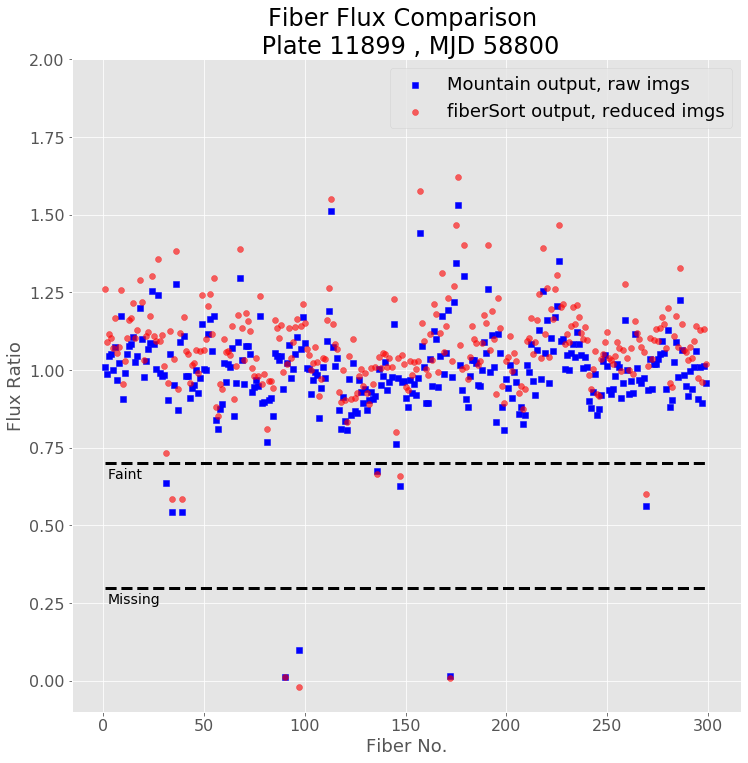

In [12]:
fiber_plotter("as1D-a-24960049.fits","as1D-a-32380009.fits","mtn-32380009.csv")

Compared to output of MJD 58800's log:

Missing fibers: [90, 97, 172] OK

Faint fibers:   [31, 34, 39, 136, 147, 269] ONE EXTRA FAINT IN LOG: No. 31.

Looking at fiber no. 31 above, **fiberSort classifies above faint threshold while the mountain code classifies below**. The classification as a faint or good fiber may be different after image reduction; minor variation between raw and 1D images is expected. Therefore, these cutoff points for both raw and 1D images should be considered in discussions of fiber performance when determining which fibers have true poor performance.